# Inverse Problems Exercises: 2022s s10 (non-physics)
https://www.umm.uni-heidelberg.de/miism/

## Notes
* Please **DO NOT** change the name of the `.ipynb` file. 
* Please **DO NOT** import extra packages to solve the tasks. 
* Please put the `.ipynb` file directly into the `.zip` archive without any intermediate folder. 

## Please provide your personal information
* full name (Name): 

YOUR ANSWER HERE

## C01b: Matching Pursuit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys

# from the nbgrader folders
sys.path.append('../../exercises')
sys.path.append('../../../exercises')

file_gaussian = 'file_gaussian.npz'
with np.load(file_gaussian) as data:
    f_true = data['f_true']
    A_psf = data['A_psf']
    list_gn = data['list_gn']

### Imaging model
The imaging model can be represented by
$$
g = h \otimes f_\text{true}
= Af_\text{true}
= \mathcal{F}^{-1}\{ \mathcal{F}\{h\} \mathcal{F}\{f_\text{true}\} \},
$$
$$
g' = g + \epsilon.
$$
* $f_\text{true}$ is the input signal
* $h$ is the point spread function (kernel)
* $\otimes$ is the convolution operator
* $A$ is the Toeplitz matrix of $h$
* $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the Fourier transform operator and inverse Fourier transform operator
* $\epsilon$ is the additive Gaussian noise
* $g$ is the filtered signal
* $g'$ is the noisy signal

### Haar wavelet transformation matrix
The Haar wavelet transformation matrix is used for Haar wavelet transformation.
* Create the Haar wavelet transformation matrix with the size of 32 (using `compute_haar_wavelet_matrix()`)
* Plot the Haar wavelets from the rows of the matrix in the subplots of `axs`
* Show 8 rows of the matrix in each subplot
* Add proper titles to the subplots

In [3]:
def compute_haar_wavelet_matrix(dim):
    """ Create Haar wavelet transformation matrix H for the
    matrix vector multiplication implementation of Haar wavelet transformation.
    This function uses the following formula to create the Haar transformation matrix:
        H_n = 1/sqrt(2)[H_(n/2) kron(1 1), I_(n/2) kron (1 -1)]
    where 'kron' denotes the kronecker product.
    The iteration starts with H_1=[1]. The normalization constant 1/sqrt(2) ensure that
    H_n^T * H_n = I, where I is identity matrix.
    
    Note: Haar wavelets are the rows of H.
    
    :param dim: dimension of square Haar wavelet transformbation matrix..
    :return: H: Haar transformation matrix with size as the power of 2 - i.e. 2, 4, 8, 16, 32, etc.
    """

    level = int(np.log2(dim))
    if (2**level < dim):
        print('error: value of input parameter is not power of 2')
        return

    # lowpass filter
    lp = np.array([[1, 1]])
    # highpass filter
    hp = np.array([[1, -1]])
    # normalizazion constant
    NC = 1/np.sqrt(2)

    H = np.array([1])

    for i in range(level):
        t1 = np.kron(H, lp)
        t2 = np.kron(np.identity(len(H)),hp)
        T = np.concatenate((t1, t2), axis=0)
        H = np.dot(NC,T)

    return H

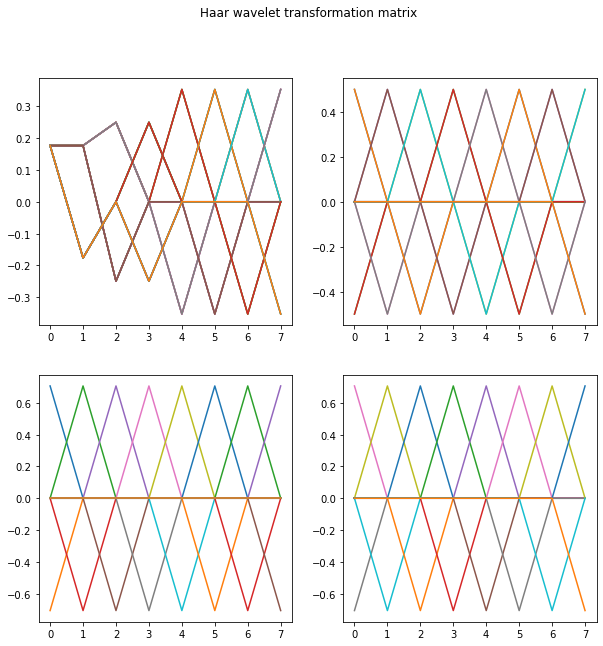

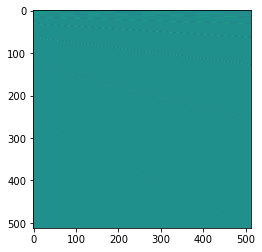

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Haar wavelet transformation matrix')

H = compute_haar_wavelet_matrix(32)
axs[0,0].plot(H[:8])
axs[0,1].plot(H[8:16])
axs[1,0].plot(H[16:24])
axs[1,1].plot(H[24:32])

plt.show()
plt.imshow(compute_haar_wavelet_matrix(512))

### Matching pursuit
To find the sparse representation of the signal, the problem is formulated as follows
$$
\arg\min_s \|s\|_0,\ \text{s. t.}\ g' = Af = A\Psi s = \Phi s,
$$
where $\Psi$ is the transform into the sparse space, and $\Phi = A\Psi$.

The solution of $s$ can be calculated by the matching pursuit method
$$
\begin{align*}
s^{(0)} &= 0 \\
f^{(0)} &= 0 \\
r^{(0)} &= \Phi s^{(0)} - g = -g \\
k^{(i)} &= \arg\max_k <r^{(i)} | \Phi_k>^2 \\
f^{(i+1)} &= f^{(i)} -  <r^{(i)} | \Phi_{k^{(i)}}> \Psi_{k^{(i)}} \\
r^{(i+1)} &= r^{(i)} -  <r^{(i)} | \Phi_{k^{(i)}}> \Phi_{k^{(i)}}
\end{align*}
$$
* Given the system matrix $A$
* Given the measurement $g'$
* Given the transform $\Psi$
* Given the number of iterations $n$
* Return the final value $f^{(n)}$ as the first output
* Return the history array of residual norm $[||r^{(0)}||, ..., ||r^{(n)}||]$ as the second output
* Implement the function `solve_matching_pursuit()` (using `numpy.array`)

In [80]:
def solve_matching_pursuit(A, gn, Psi, n):
    """ Restore the signal using Matching Pursuit Algorithm.
    
    :param A: 2d matrix A of the linear problem.
    :param gn: Observed signal.
    :param Psi: Transform matrix.
    :param n: Number of iterations.
    :return: Final f estimate and the history of residual norm
    """
    s = np.zeros(gn.shape)
    f = np.zeros(gn.shape)
    Phi = A @ Psi
    r = - gn
    list_r = [np.linalg.norm(r)]
    for i in range(n):
        k = np.argmax((r @ Phi)**2)
        f = f - np.dot(r, Phi[:,k]) * Psi[:,k] 
        r = r - np.dot(r, Phi[:,k]) * Phi[:,k] 
        list_r.append(np.linalg.norm(r))
    return f, list_r

### Signal processing 1
Process the signals as follows
* `A_1`
  - Pad zeros to the end of `A_psf` in both dimensions
  - Make the size of `A_1` the exponent of next higher power of 2 in both dimensions
* `gn_1`
  - Pad zeros to the end of `list_gn[1]`
  - Make the size of `gn_1` the exponent of next higher power of 2
* `Psi_1`: the corresponding tranform matrix (using `compute_haar_wavelet_matrix()`)
* `n_1`: 200 iterations
* `f_1`: the estimate of the input signal
* `list_r_norm_1`: the history of residual norm

Display the result
* Plot the outputs in the subplots of `axs`
* In the first subplot, show the estimated input signal and the true input signal
* In the second subplot, show the estimated measurement $Af$ and the actual measurement
* In the third subplot, show the sparse representation $s = \Psi^{-1} f$
* In the fourth subplot, show the history of residual norm
* Show the legend in each subplot

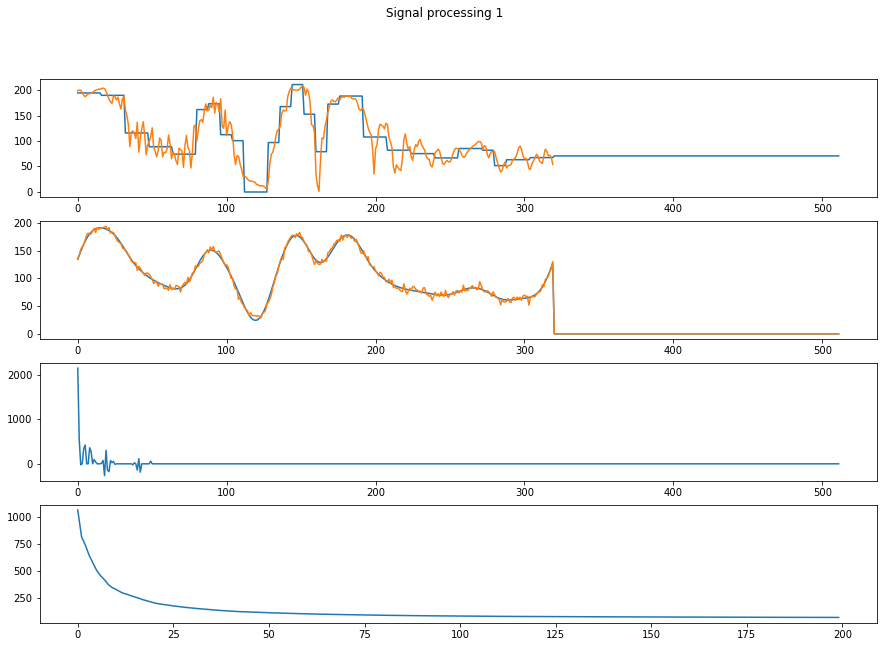

In [88]:
next_power_of_two = int(2**np.ceil(np.log2(A_psf.shape[0])))

A_1 = np.zeros((next_power_of_two, next_power_of_two))
A_1[:A_psf.shape[0], :A_psf.shape[1]] = A_psf

gn_1 = np.zeros(next_power_of_two)
gn_1[:list_gn[1].shape[0]] = list_gn[1]

Psi_1 = compute_haar_wavelet_matrix(gn_1.shape[0]).T

n_1 = 200

f_1, list_r_norm_1 = solve_matching_pursuit(A_1, gn_1, Psi_1, n_1)

fig, axs = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Signal processing 1')

axs[0].plot(f_1)
axs[0].plot(f_true)
axs[1].plot(A_1@f_1)
axs[1].plot(gn_1)
axs[2].plot(np.linalg.inv(Psi_1)@f_1)
axs[3].plot(list_r_norm_1)

In [ ]:
# This cell contains hidden tests.

shape_A_1_TEST = A_1.shape

np.testing.assert_array_equal(2**np.uint(np.log2(shape_A_1_TEST)), shape_A_1_TEST)


In [ ]:
# This cell contains hidden tests.

size_gn_1_TEST = gn_1.size

np.testing.assert_array_equal(2**np.uint(np.log2(size_gn_1_TEST)), size_gn_1_TEST)


In [ ]:
# This cell contains hidden tests.


In [ ]:
# This cell contains hidden tests.


In [ ]:
# This cell contains hidden tests.

np.testing.assert_array_equal(list_r_norm_1.size, 201)


### Signal processing 2
Process the signals as follows
* `A_2`
  - Pad zeros to the end of `A_psf` in the columns only
  - Make the size of `A_2` the exponent of next higher power of 2 in the columns only
* `gn_2`: `list_gn[1]`
* `Psi_2`: the corresponding tranform matrix (using `compute_haar_wavelet_matrix()`)
* `n_2`: 200 iterations
* `f_2`: the estimate of the input signal
* `list_r_norm_2`: the history of residual norm

Display the result
* Plot the outputs in the subplots of `axs`
* In the first subplot, show the estimated input signal and the true input signal
* In the second subplot, show the estimated measurement $Af$ and the actual measurement
* In the third subplot, show the sparse representation $s = \Psi^{-1} f$
* In the fourth subplot, show the history of residual norm
* Show the legend in each subplot

In [ ]:
next_power_of_two = int(2**np.ceil(np.log2(A_psf.shape[0])))

A_1 = np.zeros((A_psf.shape[0], next_power_of_two))
A_1[:A_psf.shape[0], :A_psf.shape[1]] = A_psf

gn_1 =  list_gn[1]

Psi_1 = compute_haar_wavelet_matrix(gn_1.shape[0]).T

n_1 = 200

f_1, list_r_norm_1 = solve_matching_pursuit(A_1, gn_1, Psi_1, n_1)

fig, axs = plt.subplots(4, 1, figsize=(15, 10))
fig.suptitle('Signal processing 2')

axs[0].plot(f_1)
axs[0].plot(f_true)
axs[1].plot(A_1@f_1)
axs[1].plot(gn_1)
axs[2].plot(np.linalg.inv(Psi_1)@f_1)
axs[3].plot(list_r_norm_1)

In [ ]:
# This cell contains hidden tests.

shape_A_2_TEST = A_2.shape

np.testing.assert_array_equal(shape_A_2_TEST[0], A_psf.shape[0])
np.testing.assert_array_equal(2**np.uint(np.log2(shape_A_2_TEST[1])), shape_A_2_TEST[1])


In [ ]:
# This cell contains hidden tests.

np.testing.assert_array_equal(gn_2.size, list_gn[1].size)


In [ ]:
# This cell contains hidden tests.


In [ ]:
# This cell contains hidden tests.


In [ ]:
# This cell contains hidden tests.

np.testing.assert_array_equal(list_r_norm_2.size, 201)
